# Assignment 4: Clustering
# by Lilian Huang

In this notebook, we explore clustering methods. 

The functions written for this purpose are in the accompanying pipeline_clust.py file, and in this notebook we demonstrate their use by applying them to the analysis of DonorsChoose data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pipeline_clust as pl
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/lilianhj/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Analysis

We apply the pipeline functionality to analyze the DonorsChoose dataset.

In [2]:
df = pd.read_csv('projects_2012_2013.csv')

In [3]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


### Pre-Processing

We create the outcome variable that, while unnecessary for clustering, will be used later in the supervised learning component.

In [4]:
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['days_to_funded'] = (df['datefullyfunded'] - df['date_posted']).dt.days
df['fundedin60'] = np.where(df['days_to_funded'] > 60, 1, 0)

We carry out data processing to prepare it for clustering; specifically, we convert non-numeric data to numeric, and impute missing values.

In [5]:
for colname in ['school_charter', 'school_magnet', 'eligible_double_your_impact_match']:
    pl.recode_booleans(df, colname, 't', 'f')

In [6]:
for colname in ['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']:
    df[colname] = df[colname].astype('category')

In [7]:
df.dtypes

projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_ncesid                                    float64
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_metro                                    category
school_district                                   object
school_county                                     object
school_charter                                     int64
school_magnet                                      int64
teacher_prefix                                  category
primary_focus_subject                           category
primary_focus_area                              category
secondary_focus_subject                         category
secondary_focus_area           

In [9]:
for colname in ['school_metro', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 
                'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']:
    print(df[colname].unique())

[urban, suburban, rural, NaN]
Categories (3, object): [urban, suburban, rural]
[Mrs., Ms., Mr., Dr.]
Categories (4, object): [Mrs., Ms., Mr., Dr.]
[Mathematics, Civics & Government, Literacy, Other, Social Sciences, ..., Extracurricular, Foreign Languages, Economics, Parent Involvement, NaN]
Length: 28
Categories (27, object): [Mathematics, Civics & Government, Literacy, Other, ..., Extracurricular, Foreign Languages, Economics, Parent Involvement]
[Math & Science, History & Civics, Literacy & Language, Applied Learning, Music & The Arts, Health & Sports, Special Needs, NaN]
Categories (7, object): [Math & Science, History & Civics, Literacy & Language, Applied Learning, Music & The Arts, Health & Sports, Special Needs]
[Visual Arts, Literature & Writing, Social Sciences, NaN, Literacy, ..., Extracurricular, Civics & Government, Other, Sports, Economics]
Length: 28
Categories (27, object): [Visual Arts, Literature & Writing, Social Sciences, Literacy, ..., Civics & Government, Other, S

In [10]:
df['school_metro_num'] = df['school_metro'].replace(['rural', 'suburban', 'urban'], [0, 1, 2])

In [11]:
df['poverty_level_num'] = df['poverty_level'].replace(['low poverty', 'moderate poverty', 
                                                       'high poverty', 'highest poverty'], [0, 1, 2, 3])

In [12]:
df['grade_level_num'] = df['grade_level'].replace(['Grades PreK-2', 'Grades 3-5', 'Grades 6-8', 'Grades 9-12'], 
                                                  [0, 1, 2, 3])

In [13]:
df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,days_to_funded,fundedin60,school_metro_num,poverty_level_num,grade_level_num
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,1498.61,31.0,0,2013-04-14,2013-05-02,18,0,2.0,3,0.0
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,282.47,28.0,1,2012-04-07,2012-04-18,11,0,2.0,3,1.0
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,1012.38,56.0,0,2012-01-30,2012-04-15,76,1,2.0,2,1.0
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,175.33,23.0,0,2012-10-11,2012-12-05,55,0,2.0,2,0.0
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,3591.11,150.0,0,2013-01-08,2013-03-25,76,1,1.0,2,0.0


In [15]:
pl.null_count(df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

In [16]:
df = pl.impute_median(df)

In [17]:
pl.null_count(df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                                 0
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

### Clustering

We now carry out the actual clustering, using k-means; we arbitrarily decide to have 3 clusters.

Rather than clustering by every feature in the dataset, we choose to focus on features that were especially of interest. We believe that this narrower focus allows us to come up with more usefully descriptive clusters.

In [19]:
assignments = pl.get_cluster_assignments(df[['school_metro_num', 'school_charter', 'school_magnet',  
                                'poverty_level_num', 'grade_level_num', 'eligible_double_your_impact_match']], 3)

This is the first cluster, with summary statistics and visualizations to show the features of the data points within this cluster.

A full description of this and the other clusters are in the accompanying report, but we can see that this cluster is characterized by:
* high poverty
* younger children
* urban schools

In [21]:
pl.cluster_summary_stats(assignments, 0)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000,60001.0
mean,1.710438,0.083299,0.081449,2.786487,0.443543,0.331078,0.0
std,0.566880,0.276335,0.273525,0.409790,0.496806,0.470605,0.0
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0
25%,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0
50%,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0
75%,2.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.0
max,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.0


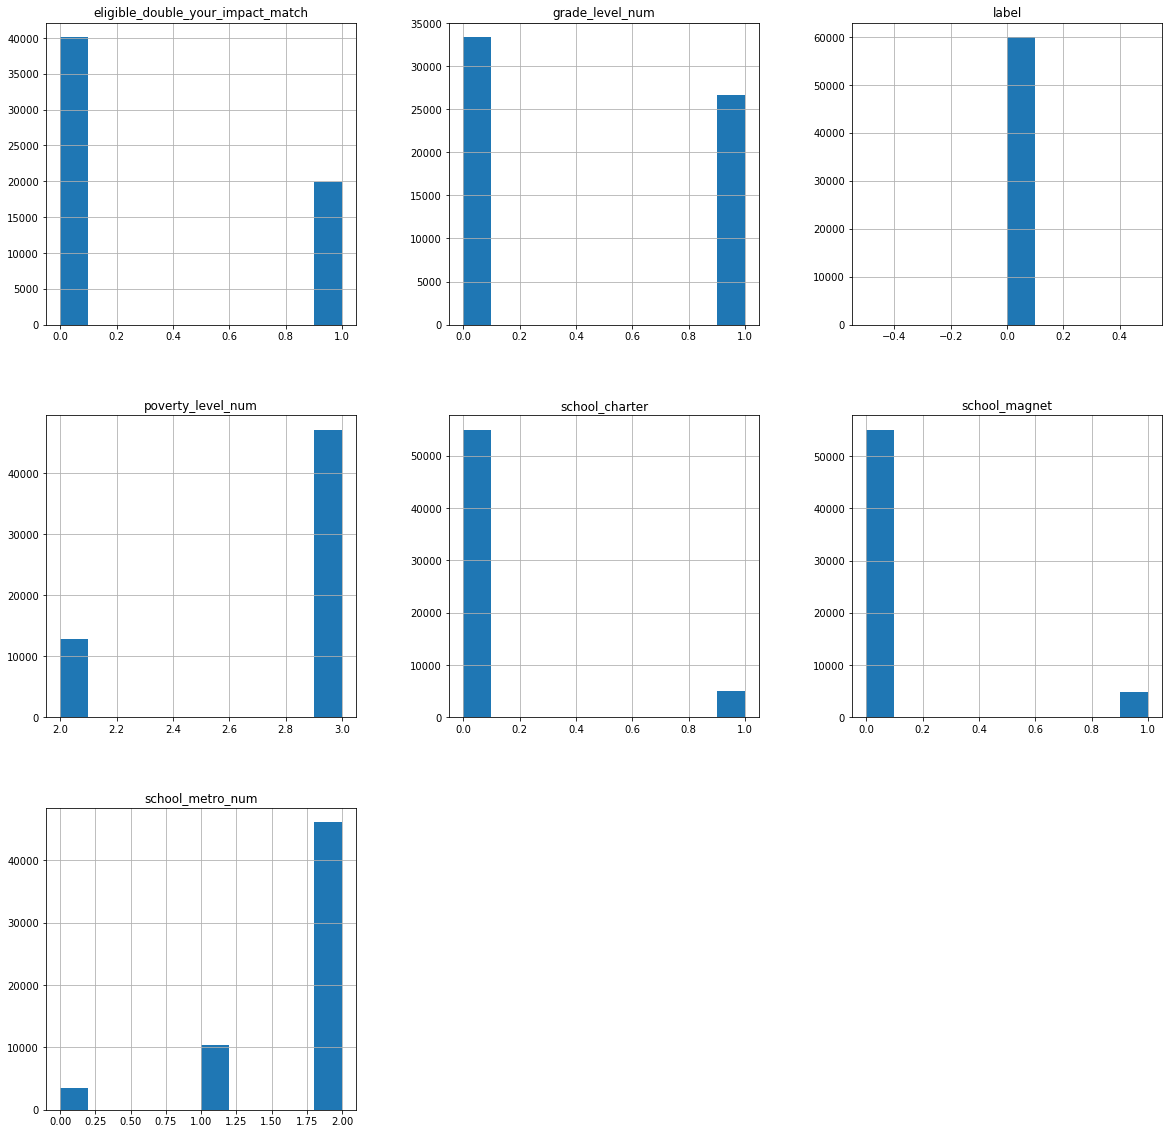

In [22]:
pl.cluster_hist(assignments, 0, 20, 20)

This is the second cluster, with summary statistics and visualizations to show the features of the data points within this cluster.

A full description of this and the other clusters are in the accompanying report, but we can see that this cluster is characterized by:
* the lowest poverty
* younger children
* suburban schools

In [23]:
pl.cluster_summary_stats(assignments, 1)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,29609.000000,29609.000000,29609.000000,29609.000000,29609.000000,29609.000000,29609.0
mean,1.019116,0.070249,0.038603,1.229829,0.605289,0.230031,1.0
std,0.705748,0.255570,0.192650,0.643148,0.647778,0.420860,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
50%,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0
75%,2.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.0
max,2.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.0


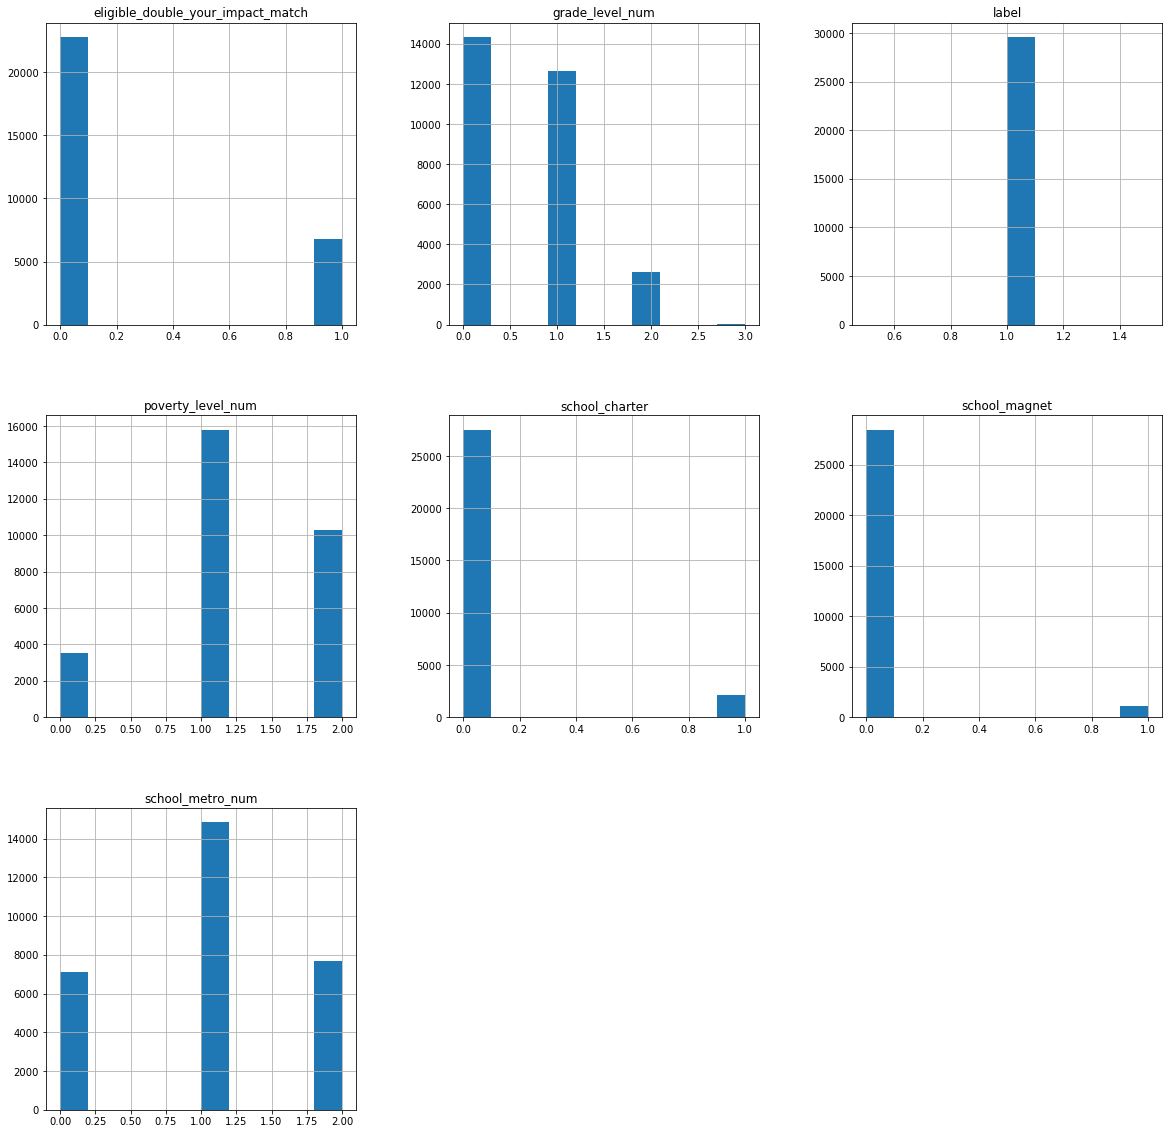

In [24]:
pl.cluster_hist(assignments, 1, 20, 20)

This is the third cluster, with summary statistics and visualizations to show the features of the data points within this cluster.

A full description of this and the other clusters are in the accompanying report, but we can see that this cluster is characterized by:
* varying poverty
* older children
* mostly urban schools

In [25]:
pl.cluster_summary_stats(assignments, 2)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,35366.000000,35366.000000,35366.000000,35366.000000,35366.000000,35366.000000,35366.0
mean,1.562602,0.128881,0.132133,2.472375,2.466606,0.294435,2.0
std,0.680460,0.335073,0.338640,0.695657,0.498891,0.455795,0.0
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.0
25%,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,2.0
50%,2.000000,0.000000,0.000000,3.000000,2.000000,0.000000,2.0
75%,2.000000,0.000000,0.000000,3.000000,3.000000,1.000000,2.0
max,2.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.0


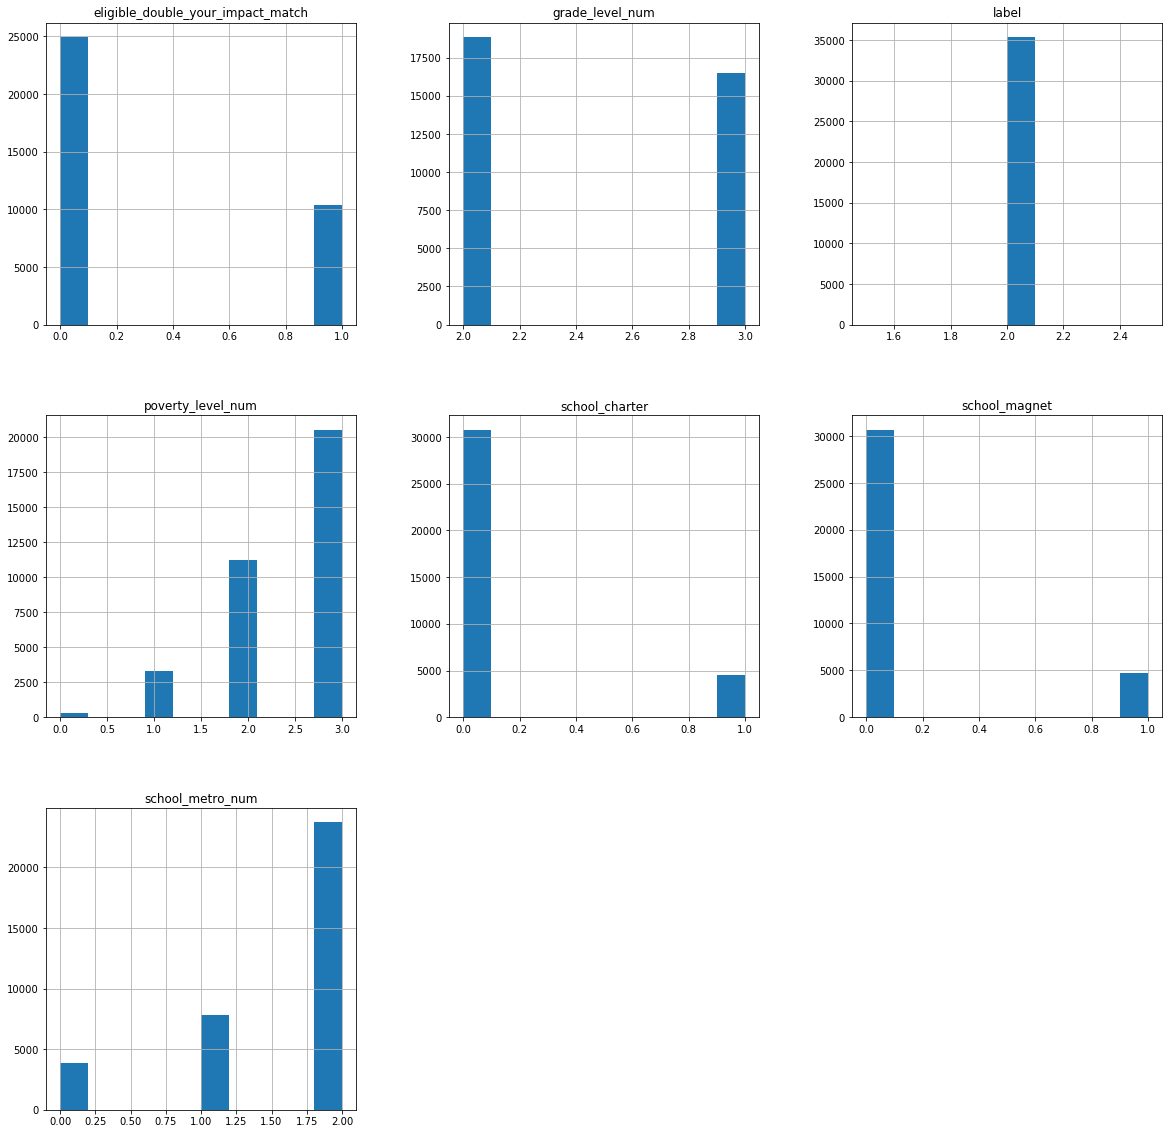

In [26]:
pl.cluster_hist(assignments, 2, 20, 20)

### Top 5% of At-Risk Projects

We now use a logistic regression model to predict which projects are unlikely to be fully funded (with the same features used for clustering), and identify the top 5% of those projects. 

In [27]:
xvars = df[['school_metro_num', 'school_charter', 'school_magnet',  
            'poverty_level_num', 'grade_level_num', 'eligible_double_your_impact_match']]

In [28]:
yvar = df['fundedin60']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(xvars, yvar, test_size=0.25,random_state=0)

In [30]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
y_preds = logreg.predict_proba(X_test)[:,1]

In [35]:
results = pd.DataFrame()
results['index_num'] = y_test.index
results['prob'] = y_preds

In [37]:
results = results.sort_values(by='prob', ascending=False)

In [39]:
results.head()

,index_num,prob
14123,31616,0.393347
14308,107005,0.393347
30102,9122,0.393347
22288,89831,0.393347
338,93186,0.393347


In [40]:
top5pct = results.head(int(len(results)*(5/100)))

In [41]:
top5pct.head(n=20)

,index_num,prob
14123,31616,0.393347
14308,107005,0.393347
30102,9122,0.393347
22288,89831,0.393347
338,93186,0.393347
25131,61803,0.393347
18645,103498,0.393347
28392,98531,0.393347
20413,14558,0.393347
28341,65083,0.393347


In [42]:
top5pctX = X_test[X_test.index.isin(top5pct['index_num'])]

In [43]:
top5pctX.head(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match
111514,0.0,0,0,2,0.0,0
48901,0.0,0,0,2,2.0,0
65429,0.0,0,0,1,1.0,0
54632,0.0,0,0,2,0.0,0
31580,0.0,0,0,2,2.0,0
27666,0.0,0,0,1,0.0,0
92051,0.0,0,0,1,0.0,0
112431,0.0,0,0,1,0.0,0
33387,0.0,0,0,2,0.0,0
96652,0.0,0,0,2,0.0,0


Having identified the top 5% of projects at risk of not being fully funded, we carry out clustering on these projects. Again, we use k-means with 3 clusters.

In [44]:
top_assignments = pl.get_cluster_assignments(top5pctX, 3)

In [45]:
top_assignments.head(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
111514,0.0,0,0,2,0.0,0,0
48901,0.0,0,0,2,2.0,0,2
65429,0.0,0,0,1,1.0,0,1
54632,0.0,0,0,2,0.0,0,0
31580,0.0,0,0,2,2.0,0,2
27666,0.0,0,0,1,0.0,0,1
92051,0.0,0,0,1,0.0,0,1
112431,0.0,0,0,1,0.0,0,1
33387,0.0,0,0,2,0.0,0,0
96652,0.0,0,0,2,0.0,0,0


These are the summary statistics and visualizations for the first cluster. Again, a description is given in the accompanying report.

In [46]:
pl.cluster_summary_stats(top_assignments, 0)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,642.0,642.0,642.0,642.0,642.000000,642.0,642.0
mean,0.0,0.0,0.0,2.0,0.453271,0.0,0.0
std,0.0,0.0,0.0,0.0,0.498200,0.0,0.0
min,0.0,0.0,0.0,2.0,0.000000,0.0,0.0
25%,0.0,0.0,0.0,2.0,0.000000,0.0,0.0
50%,0.0,0.0,0.0,2.0,0.000000,0.0,0.0
75%,0.0,0.0,0.0,2.0,1.000000,0.0,0.0
max,0.0,0.0,0.0,2.0,1.000000,0.0,0.0


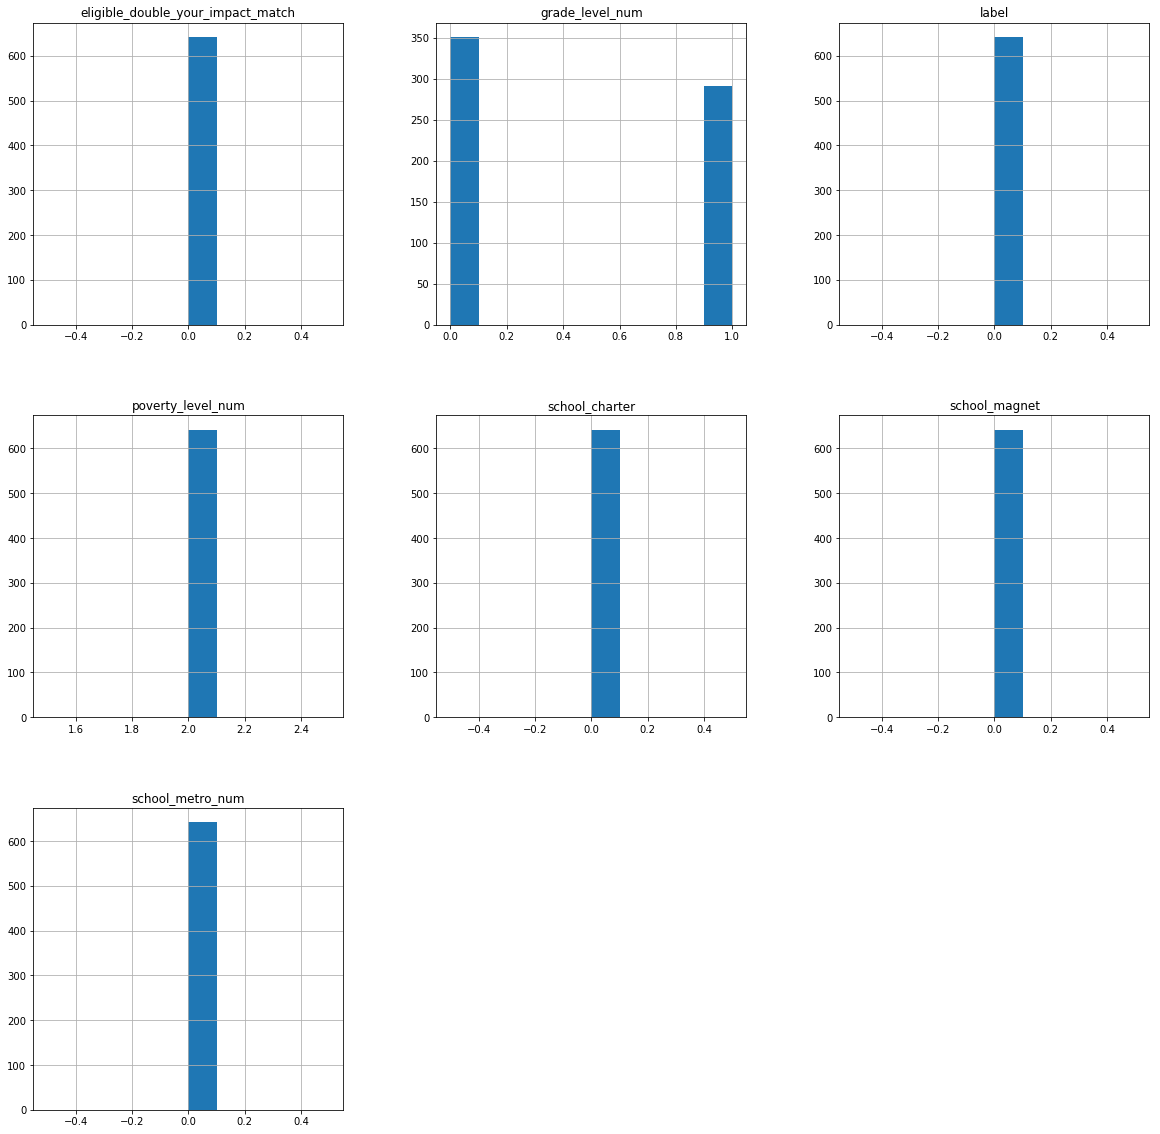

In [47]:
pl.cluster_hist(top_assignments, 0, 20, 20)

These are the summary statistics and visualizations for the second cluster. Again, a description is given in the accompanying report.

In [48]:
pl.cluster_summary_stats(top_assignments, 1)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,537.0,537.000000,537.000000,537.000000,537.000000,537.0,537.0
mean,0.0,0.003724,0.003724,0.864060,0.435754,0.0,1.0
std,0.0,0.060971,0.060971,0.343045,0.496318,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.0
50%,0.0,0.000000,0.000000,1.000000,0.000000,0.0,1.0
75%,0.0,0.000000,0.000000,1.000000,1.000000,0.0,1.0
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.0


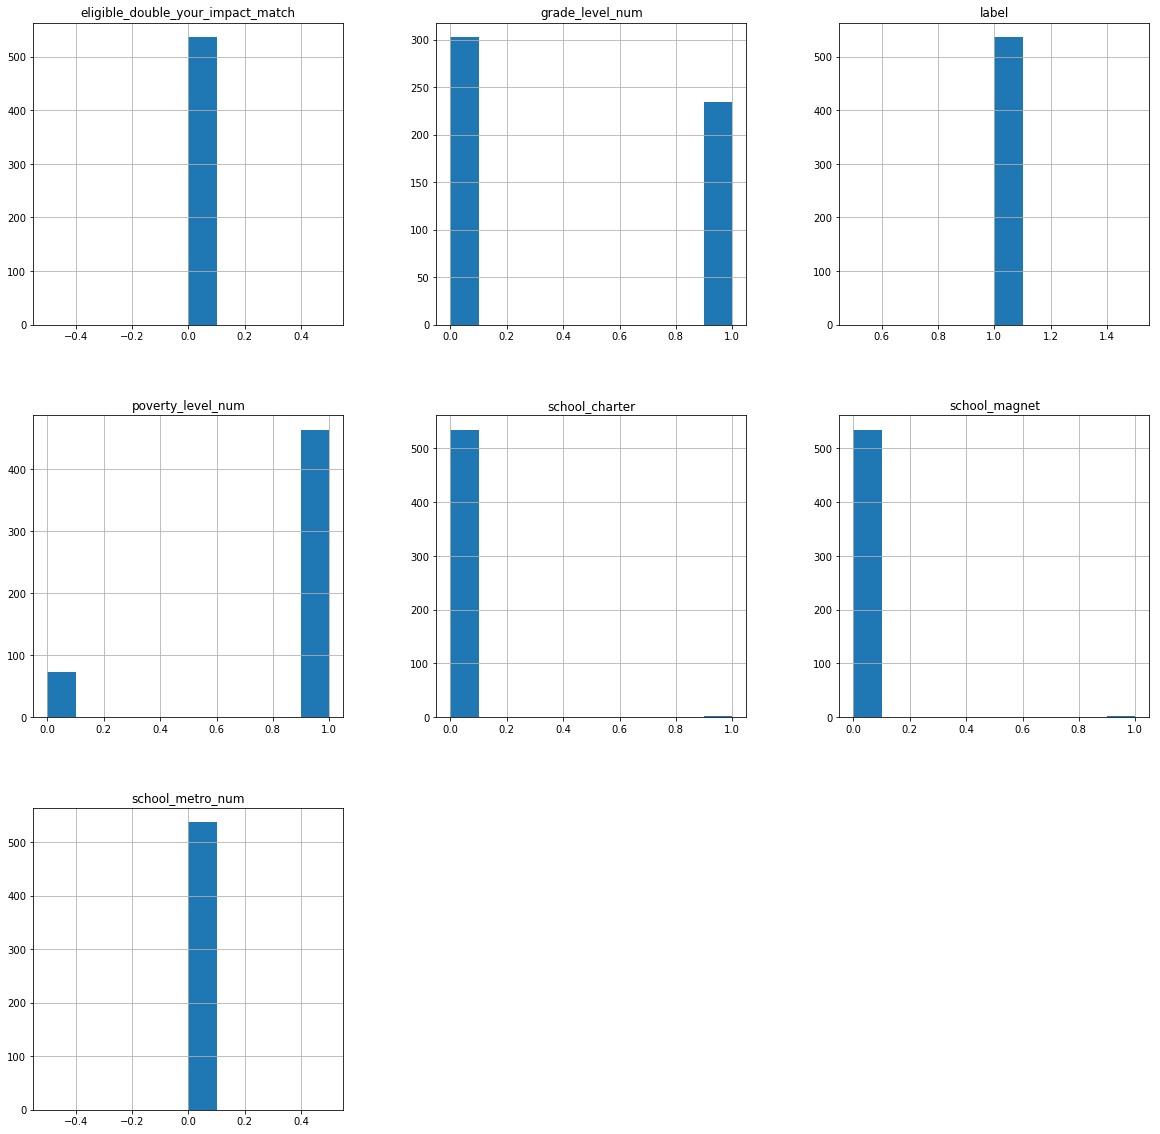

In [49]:
pl.cluster_hist(top_assignments, 1, 20, 20)

These are the summary statistics and visualizations for the third cluster. Again, a description is given in the accompanying report.

In [50]:
pl.cluster_summary_stats(top_assignments, 2)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
count,383.0,383.0,383.000000,383.000000,383.000000,383.0,383.0
mean,0.0,0.0,0.002611,1.368146,2.229765,0.0,2.0
std,0.0,0.0,0.051098,0.567652,0.421232,0.0,0.0
min,0.0,0.0,0.000000,0.000000,2.000000,0.0,2.0
25%,0.0,0.0,0.000000,1.000000,2.000000,0.0,2.0
50%,0.0,0.0,0.000000,1.000000,2.000000,0.0,2.0
75%,0.0,0.0,0.000000,2.000000,2.000000,0.0,2.0
max,0.0,0.0,1.000000,2.000000,3.000000,0.0,2.0


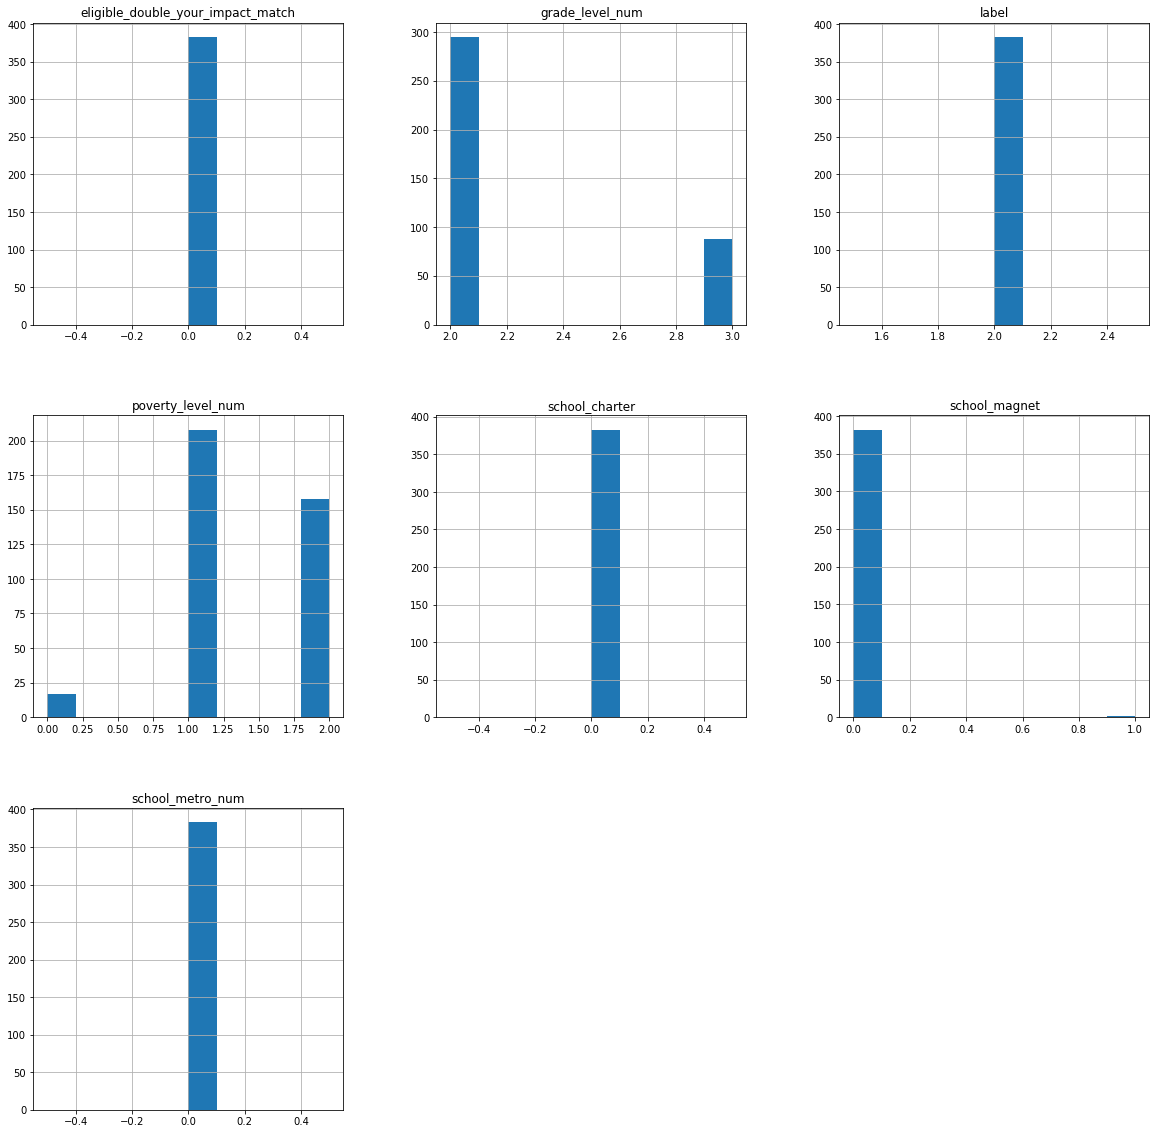

In [51]:
pl.cluster_hist(top_assignments, 2, 20, 20)

## Interactive Functionality

This section demonstrates the functions that the user can apply to interact with clusters.

First we show the current distribution of clusters for the full dataset.

In [52]:
assignments['label'].value_counts()

0    60001
2    35366
1    29609
Name: label, dtype: int64

In [53]:
assignments.head(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
0,2.0,0,0,3,0.0,0,0
1,2.0,0,0,3,1.0,1,0
2,2.0,0,0,2,1.0,0,0
3,2.0,0,1,2,0.0,0,0
4,1.0,0,0,2,0.0,0,1
5,2.0,0,0,3,1.0,0,0
6,0.0,0,0,2,1.0,0,1
7,2.0,0,0,3,3.0,0,2
8,2.0,0,0,2,1.0,0,0
9,1.0,0,0,3,0.0,0,0


### Merging Clusters

The user can merge clusters into one using the merge_clusters function, which is documented in the pipeline file as well.

Inputs:
* a Pandas dataframe with the assigned cluster labels
* list of labels of clusters to be merged
* replacement label

Here we merge together clusters 0 and 2 into cluster 2.

In [54]:
merge_test = pl.merge_clusters(assignments, [2, 0], 2)

In [55]:
merge_test['label'].value_counts()

2    95367
1    29609
Name: label, dtype: int64

In [56]:
merge_test.head(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
0,2.0,2,2,3,2.0,2,2
1,2.0,2,2,3,1.0,1,2
2,2.0,2,2,2,1.0,2,2
3,2.0,2,1,2,2.0,2,2
4,1.0,2,2,2,2.0,2,1
5,2.0,2,2,3,1.0,2,2
6,2.0,2,2,2,1.0,2,1
7,2.0,2,2,3,3.0,2,2
8,2.0,2,2,2,1.0,2,2
9,1.0,2,2,3,2.0,2,2


### Reclustering

The user can recluster with a new desired number of clusters using the recluster function, which is documented in the pipeline file as well.

Inputs:
* a Pandas dataframe with the assigned cluster labels
* new number of clusters wanted

Here we recluster the data into 4 clusters.

In [57]:
reclus_test = pl.recluster(assignments, 4)

In [58]:
reclus_test['label'].value_counts()

2    46096
0    33624
1    24213
3    21043
Name: label, dtype: int64

In [59]:
reclus_test.head(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
0,2.0,0,0,3,0.0,0,2
1,2.0,0,0,3,1.0,1,2
2,2.0,0,0,2,1.0,0,2
3,2.0,0,1,2,0.0,0,2
4,1.0,0,0,2,0.0,0,1
5,2.0,0,0,3,1.0,0,2
6,0.0,0,0,2,1.0,0,1
7,2.0,0,0,3,3.0,0,0
8,2.0,0,0,2,1.0,0,2
9,1.0,0,0,3,0.0,0,1


### Splitting Clusters

The user can split a specific cluster into multiple new clusters using the split_cluster function, which is documented in the pipeline file as well.

Inputs:
* a Pandas dataframe with the assigned cluster labels
* the label of the specific cluster to be split
* the specific number of new clusters to be created

Here we split cluster 1 into 2 clusters. The other clusters remain intact.

In [60]:
split_test = pl.split_cluster(assignments, 1, 2)

In [61]:
split_test['label'].value_counts()

0        60001
2        35366
new_0    16353
new_1    13256
Name: label, dtype: int64

In [63]:
split_test.tail(n=20)

,school_metro_num,school_charter,school_magnet,poverty_level_num,grade_level_num,eligible_double_your_impact_match,label
124889,1.0,0,0,1,2.0,0,new_0
124891,2.0,0,0,1,0.0,0,new_0
124893,0.0,0,0,1,2.0,0,new_1
124896,0.0,0,0,1,2.0,0,new_1
124897,1.0,0,0,0,0.0,0,new_0
124900,1.0,0,0,1,0.0,1,new_0
124904,2.0,0,0,1,0.0,1,new_0
124905,1.0,0,0,1,1.0,1,new_0
124910,0.0,0,0,2,0.0,0,new_1
124920,1.0,0,0,1,1.0,1,new_0
